# **ML for GW Astronomy: GW classifier using CNN algorithms**

Dr. Manuel David Morales (manueld.morales@academicos.udg.mx)<br/>
<i>CUCEI, Universidad de Guadalajara</i><br/>

For this second code, we start from a dataset that contains TF spectrograms that are similar to those we generated in the Data Preparation notebook, with GW signals of the model CCSNe Scheideger et al. 2010. The goal: design a Convolutional Neural Network (CNN) and apply it to the problem of binary classification between windows samples which have, and don't have, a CCSNe GW transient.

The structure of this notebook is similar to most of data science projects with ML techniques:

1.   **Data import and preparation**
2.   **Define the deep learning arquitecture to use**
3.   **Model training, testing, and evaluation**



## **Part 1: Settings**

In [ ]:
# ------> Library imports

# Files/folders management
import os

# Data analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

# Scientific computing
import scipy as sp
from scipy import interpolate, signal

from functools import partial

# Machine/Deep learning tools
import sklearn.metrics as metrics
from sklearn import model_selection
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
# ------> Library requeriments

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## **Part 2: Data import/conversion**

For this notebook, we draw on samples of spectrograms, codified as flatten images (vector of pixels). This spectrograms was obtained from strain time series already whitened and band-pass filtered. The conversion to the TF representation was made through the Q-transform.

There are two types of samples. Type 1, in which a simulated CCSNe GW, Scheideger et al. 2010 (https://doi.org/10.1051/0004-6361/200913220) was injected in real noise data of LIGO detectors. Type 0, which are samples of only noise, without GW injection.

For data augmentation purposes, in this case, 5 samples were extracted around the same GW signal injection through (sliding window approach): 3 of only noise and 2 showing noise plus the GW signal.

This dataset in JSON format was generated by a former B.Sc.student of our group, Aldo Álvarez, and Prof. Javier M. Antelis.

See the paper: https://bit.ly/RCS_CCSNeGW_CNNclassifier.

In [ ]:
import random
from google_drive_downloader import GoogleDriveDownloader

class Constants:

    SEED = 0

    # Paths to the data files
    dfJob2 = '/dfJob2.json'
    dfJob3 = '/dfJob3.json'
    dfJob4 = '/dfJob4.json'
    dfJob5 = '/dfJob5.json'

constants = Constants
random.seed(constants.SEED)
np.random.seed(constants.SEED)

!wget -O /dfJob2.json https://www.dropbox.com/s/i7c1oxr9fo0py8a/DataJob2_Factor31.62.json?dl=0
!wget -O /dfJob3.json https://www.dropbox.com/s/9fgfigfz9np6k6y/DataJob3_Factor31.62.json?dl=0
!wget -O /dfJob4.json https://www.dropbox.com/s/8a1wpwfadfhecbt/DataJob4_Factor31.62.json?dl=0
!wget -O /dfJob5.json https://www.dropbox.com/s/h1aiw2ytan9yl9n/DataJob5_Factor31.62.json?dl=0

--2023-08-17 23:21:41--  https://www.dropbox.com/s/i7c1oxr9fo0py8a/DataJob2_Factor31.62.json?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/i7c1oxr9fo0py8a/DataJob2_Factor31.62.json [following]
--2023-08-17 23:21:41--  https://www.dropbox.com/s/raw/i7c1oxr9fo0py8a/DataJob2_Factor31.62.json
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc809cf8f32a31f01dc5eceda49a.dl.dropboxusercontent.com/cd/0/inline/CB_N0uzdUmY0mM2qwLiV3rYDbNcoo5ZWaF9nCq_EvIqfUEaifYF0jzLzwLCC6OdCrm0VYZbOWPqGQ-tq0yaSK8ITkSJI3SUgdGw1LS02CAUMAeOm8J3RxxAmSO30vO90VyAnSOh-qjfgK8fZUUMk4WDx/file# [following]
--2023-08-17 23:21:42--  https://uc809cf8f32a31f01dc5eceda49a.dl.dropboxusercontent.com/cd/0/inline/CB_N0uzdUmY0mM2qwLiV3rYDbNcoo5ZWaF9nCq_EvIqfUEaifYF0jzLzwL

In [ ]:
# ------> Convert a JSON strings to pandas dataframe

dfJob2 = pd.read_json(constants.dfJob2)
dfJob3 = pd.read_json(constants.dfJob3)
dfJob4 = pd.read_json(constants.dfJob4)
dfJob5 = pd.read_json(constants.dfJob5)

In [ ]:
# ------> Select columns with useful information

dfJob2 = dfJob2.iloc[:, np.r_[0:5,7]]
dfJob3 = dfJob3.iloc[:, np.r_[0:5,7]]
dfJob4 = dfJob4.iloc[:, np.r_[0:5,7]]
dfJob5 = dfJob5.iloc[:, np.r_[0:5,7]]

# ------> Explore a dataframe

dfJob2.head()

,Pixels H1,Pixels L1,Twin,GW injection,Template,Distance
0,"[[0.6671221011, 0.8246112875, 1.0935741992, 1....","[[0.6268522979000001, 0.2885270893, 0.12907088...",869.170290,1,sch3,0.031626
1,"[[0.1273723069, 0.027398567300000003, 0.000364...","[[1.5275692769, 1.6736162632, 1.5662285443, 1....",10.491783,0,NaN,0.031626
2,"[[0.9715096099, 1.0902210682, 1.25730067109999...","[[2.8905482979, 2.5858256658, 2.0183065708, 1....",10.491783,1,sch2,0.031626
3,"[[1.1038850136, 1.3463503, 1.7232404994000001,...","[[0.7286555221000001, 0.49838899600000003, 0.3...",890.915274,0,NaN,0.031626
4,"[[2.129061328, 2.4446815326999998, 2.632915256...","[[7.090021403, 4.6660909789, 2.6294095984, 1.2...",1149.403197,0,NaN,0.031626



*   Pixels H1 and Pixels L1 are the images.
*   Twin, in this case, is the initial time where a window of 0.5 seconds were extracted from the original strain data segment.
*   GW injection is a label, 0 or 1, denoting the absence or presence (total or partial) of a gravitational wave, respectively.
*   Template is the type of GW present if GW_injection=1 samples. For Scheideger et al. 2010, we have two models: **sch1** and **sch2**.

In [ ]:
print(type(dfJob2['Pixels L1'].iloc[0]))
print(type(dfJob2['Pixels H1'].iloc[0]))

<class 'list'>
<class 'list'>


In [ ]:
# ------> Convert pixels from list to numpy arrays

dfJob2['Pixels H1'] = dfJob2['Pixels H1'].apply(lambda x: np.array(x))
dfJob2['Pixels L1'] = dfJob2['Pixels L1'].apply(lambda x: np.array(x))

dfJob3['Pixels H1'] = dfJob3['Pixels H1'].apply(lambda x: np.array(x))
dfJob3['Pixels L1'] = dfJob3['Pixels L1'].apply(lambda x: np.array(x))

dfJob4['Pixels H1'] = dfJob4['Pixels H1'].apply(lambda x: np.array(x))
dfJob4['Pixels L1'] = dfJob4['Pixels L1'].apply(lambda x: np.array(x))

dfJob5['Pixels H1'] = dfJob5['Pixels H1'].apply(lambda x: np.array(x))
dfJob5['Pixels L1'] = dfJob5['Pixels L1'].apply(lambda x: np.array(x))

In [ ]:
print(type(dfJob2['Pixels L1'].iloc[0]))
print(type(dfJob2['Pixels H1'].iloc[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## **Part 3: Dataset preparation**

In [ ]:
# ------> dfJobs concatenation

print("dfJob2 lenght: ", len(dfJob2))
print("dfJob3 lenght: ", len(dfJob3))
print("dfJob4 lenght: ", len(dfJob4))
print("dfJob5 lenght: ", len(dfJob5))

c = pd.concat([dfJob2,dfJob3,dfJob4,dfJob5])
c = c.reset_index(drop=True)

print("")
print("Lenght of c (concatenation):", len(c))

dfJob2 lenght:  366
dfJob3 lenght:  366
dfJob4 lenght:  366
dfJob5 lenght:  366

Lenght of c (concatenation): 1464


In [ ]:
# The above dataset has images of dimension 48X48 mostly. However, the are
# some images of dimension 47X48 in H1 data, so we need to filter that data.
# (This was a small error that occurred during the process of window samples
# extractions from the original stran data segements)

# ------> We extract images of 48x48 pixels, only.

quit = []
for i in range(len(c)):
  if c['Pixels H1'].iloc[i].shape != (48,48) :
    quit.append(i)

c = c.drop(quit)

print("Lenght of reduced c dataframe of 48x48 images only:", len(c))
display(c)

Lenght of reduced c dataframe of 48x48 images only: 1417


,Pixels H1,Pixels L1,Twin,GW injection,Template,Distance
0,"[[0.6671221011, 0.8246112875, 1.0935741992, 1....","[[0.6268522979000001, 0.2885270893, 0.12907088...",869.170290,1,sch3,0.031626
1,"[[0.1273723069, 0.027398567300000003, 0.000364...","[[1.5275692769, 1.6736162632, 1.5662285443, 1....",10.491783,0,NaN,0.031626
2,"[[0.9715096099, 1.0902210682, 1.25730067109999...","[[2.8905482979, 2.5858256658, 2.0183065708, 1....",10.491783,1,sch2,0.031626
3,"[[1.1038850136, 1.3463503, 1.7232404994000001,...","[[0.7286555221000001, 0.49838899600000003, 0.3...",890.915274,0,NaN,0.031626
4,"[[2.129061328, 2.4446815326999998, 2.632915256...","[[7.090021403, 4.6660909789, 2.6294095984, 1.2...",1149.403197,0,NaN,0.031626
...,...,...,...,...,...,...
1459,"[[2.2254580132, 1.9484042225, 1.6321143212, 1....","[[0.7899265942, 0.6460288981, 0.48384361940000...",969.627510,0,NaN,0.031626
1460,"[[0.3179468731, 0.2854395753, 0.2616697028, 0....","[[1.7587076697000001, 1.1955678493, 0.74485918...",949.190407,0,NaN,0.031626
1461,"[[0.565950307, 0.4385646884, 0.2924311798, 0.1...","[[0.0352043911, 0.1223006153, 0.2783929472, 0....",770.786802,0,NaN,0.031626
1462,"[[1.064430518, 1.0063083303, 0.9020011592, 0.7...","[[1.1746721467, 1.6418202721, 2.1477477656, 2....",110.750426,0,NaN,0.031626


### **Features: Pixels H1 and L1**

In [ ]:
# ------> Reshape H1 pixels

# Select "Pixels H1" column from c dataframe
H1 = c['Pixels H1']

# 2D arrays preparation
H1_arr = np.empty((0,48,48), dtype=float)

# Fill the 2D arrays
for i in range(len(H1)):
  a = H1.iloc[i]
  H1_arr = np.append(H1_arr, a.reshape(1,48,48), axis=0)

# Check the dimension
print("Dimension of H1 pixels:", H1_arr.shape)

Dimension of H1 pixels: (1417, 48, 48)


In [ ]:
# ------> Reshape L1 pixels

# Select "Pixels L1" column from c dataframe
L1 = c['Pixels L1']

# 2D arrays preparation
L1_arr = np.empty((0,48,48), dtype=float)

# Fill the 2D arrays
for i in range(len(L1)):
  a = L1.iloc[i]
  L1_arr = np.append(L1_arr, a.reshape(1,48,48), axis=0)

# Check the dimension
print("Dimension of L1 pixels:", L1_arr.shape)

Dimension of L1 pixels: (1417, 48, 48)


In [ ]:
# ------> Reshape H1 and L1 pixels, together

# 2D (x 2 channels) arrays preparation
H1L1_arr = np.empty((0,48,48,2), dtype=float)

# Fill the 2D arrays (x 2 channels)
for i in range(len(H1_arr)):
  x = np.append(H1_arr[i].reshape(48,48,1), L1_arr[i].reshape(48,48,1), axis=2)
  H1L1_arr = np.append(H1L1_arr, x.reshape(1,48,48,2), axis=0)

# Check the dimension
print("Dimension of H1+L1 pixels:", H1L1_arr.shape)


Dimension of H1+L1 pixels: (1417, 48, 48, 2)


### **Target class: GW injection**

In [ ]:
# ------> Reshape target label, together

# Select "GW injection" column from c dataframe
GW_injection = c['GW injection']

# Target list preparation
classes = []

# Fill the list and convert tu numpy array
for i in range(len(GW_injection)):
  classes.append(GW_injection.iloc[i])
classes = np.array(classes)

# Check the dimension
print("Dimension of classes vector:", classes.shape)

Dimension of classes vector: (1417,)


### **Split: Train / Validation / Test**

#### **Single-interferometer data**

We perform this split for H1 single-inteferometer data. However, the procedure is exactly the same for L1 data.

In [ ]:
# Train (70%) and Test (30%)
X_train, X_test, y_train, y_test = train_test_split(H1_arr, classes, test_size=0.3, random_state=43)

# Check dimensions
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((991, 48, 48), (426, 48, 48), (991,), (426,))

In [ ]:
# Train (90%) and Validation (10%)
X_train, X_vali, y_train, y_vali = train_test_split(X_train, y_train, test_size=0.1, random_state=43)

# Check dimensions
X_train.shape, X_vali.shape, y_train.shape, y_vali.shape

((891, 48, 48), (100, 48, 48), (891,), (100,))

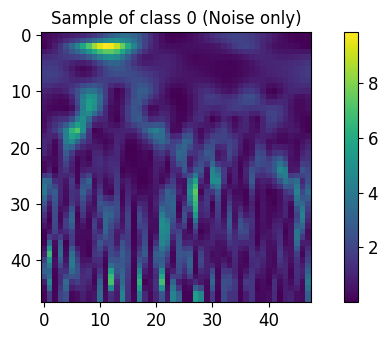

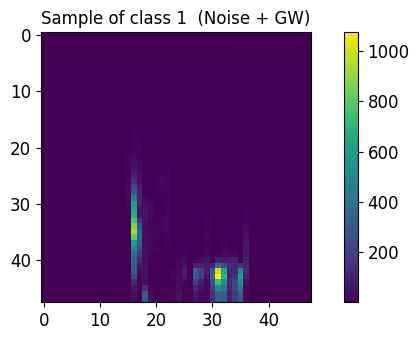

In [ ]:
# ------> Plot two representative samples of the train set.

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
data2D = X_train[0]
im = plt.imshow(data2D, cmap="viridis")
plt.colorbar(im)
plt.title("Sample of class 0 (Noise only)")
plt.show()

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
data2D = X_train[7]
im = plt.imshow(data2D, cmap="viridis")
plt.colorbar(im)
plt.title("Sample of class 1  (Noise + GW)")
plt.show()

#### **H1 and L1 combined data**

In [ ]:
# Train (70%) and Test (30%)
Xall_train, Xall_test, yall_train, yall_test = train_test_split(H1L1_arr, classes, test_size=0.3, random_state=43)

# Check dimensions
Xall_train.shape, Xall_test.shape, yall_train.shape, yall_test.shape

((991, 48, 48, 2), (426, 48, 48, 2), (991,), (426,))

In [ ]:
# Train (90%) and Validation (10%)
Xall_train, Xall_vali, yall_train, yall_vali = train_test_split(Xall_train, yall_train, test_size=0.1, random_state=43)

# Check dimensions
Xall_train.shape, Xall_vali.shape, yall_train.shape, yall_vali.shape

((891, 48, 48, 2), (100, 48, 48, 2), (891,), (100,))

## **Part 4: CNN architecture (LeNet)**

<div>
<img src="https://drive.google.com/uc?id=1B8NoPWXWv5WwhLc59MYQ0z-MIBpF4eB3" width="800"/>
</div>

This is the basic architecture that we used for detecting CBC GW signals in Morales et al. 2021 (https://doi.org/10.3390/s21093174)

In [ ]:
# Define CNN Classes
class_names = ['Noise','Noise + CCSNeGW']

## **Part 5: Single-interferometer data analysis**

In [ ]:
# ------> Build the CNN architecture (with three stacks)

modelLeNet = keras.Sequential()

# First stack
modelLeNet.add(keras.layers.Conv2D(16, (3,3), padding = "same",
                                   activation='relu', input_shape=(48, 48, 1)))
modelLeNet.add(keras.layers.MaxPooling2D((2,2)))

# Second stack
modelLeNet.add(keras.layers.Conv2D(32 , (3,3) , activation='relu'))
modelLeNet.add(keras.layers.MaxPooling2D((2,2)))

# Third stack
modelLeNet.add(keras.layers.Conv2D(64, (3,3) , activation='relu'))


# Classification
modelLeNet.add(keras.layers.Flatten())
modelLeNet.add(keras.layers.Dense(64, activation='relu'))
modelLeNet.add(keras.layers.Dense(2, activation='softmax'))

# ------> Print the summary of the model

modelLeNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 5184)              0

In [ ]:
# ------> Train the LeNet model

modelLeNet.compile(optimizer='sgd',
               loss=keras.losses.sparse_categorical_crossentropy,
               metrics=['accuracy'])

history = modelLeNet.fit(X_train, y_train, batch_size = 28, epochs = 15, validation_data = (X_vali, y_vali))

Epoch 1/15
32/32 [==============================] - 11s 22ms/step - loss: 2.6417 - accuracy: 0.8698 - val_loss: 0.4201 - val_accuracy: 0.8300
Epoch 2/15
32/32 [==============================] - 0s 5ms/step - loss: 0.3385 - accuracy: 0.8844 - val_loss: 0.3529 - val_accuracy: 0.8300
Epoch 3/15
32/32 [==============================] - 0s 5ms/step - loss: 0.2702 - accuracy: 0.8923 - val_loss: 0.2793 - val_accuracy: 0.8500
Epoch 4/15
32/32 [==============================] - 0s 5ms/step - loss: 0.2306 - accuracy: 0.9080 - val_loss: 0.2211 - val_accuracy: 0.9100
Epoch 5/15
32/32 [==============================] - 0s 5ms/step - loss: 0.2097 - accuracy: 0.9270 - val_loss: 0.2026 - val_accuracy: 0.9100
Epoch 6/15
32/32 [==============================] - 0s 6ms/step - loss: 0.1878 - accuracy: 0.9327 - val_loss: 0.1947 - val_accuracy: 0.9300
Epoch 7/15
32/32 [==============================] - 0s 5ms/step - loss: 0.1740 - accuracy: 0.9405 - val_loss: 0.1578 - val_accuracy: 0.9400
Epoch 8/15
32/32 [

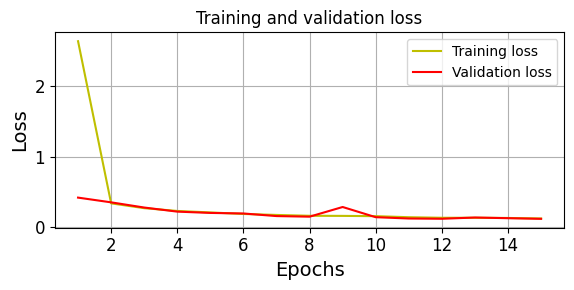

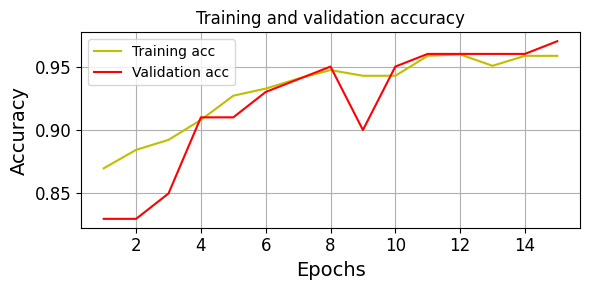

In [ ]:
# ------> Plot loss and accuracy during the training and validation

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Epochs
epochs = range(1, len(loss) + 1)

# Plot the curves

plt.figure(figsize=(6,3))
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(6,3))
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# ------> Compute test accuracy once applied the trained model

test_loss, test_acc = modelLeNet.evaluate(X_test, y_test)
print('Accuracy ', test_acc)

14/14 [==============================] - 0s 10ms/step - loss: 0.1565 - accuracy: 0.9554
Accuracy  0.9553990364074707


In [ ]:
# ------> Obtain prediccions of the model

predictions = modelLeNet.predict(X_test)
print("Predictions dim:", predictions.shape)

predicted_labels = np.zeros(len(predictions))

for i in range(len(predictions)):
    predicted_labels[i] = int(np.argmax(predictions[i]))
print("Predicted labels dim:", predicted_labels.shape)

print("")
print("-----------------------")
print("For example, two predictions:")
print("")
print("prediction: ", predictions[0])
print("predicted_label: ", predicted_labels[0])
print("")
print("prediction: ", predictions[4])
print("predicted_label: ", predicted_labels[4])

14/14 [==============================] - 0s 3ms/step
Predictions dim: (426, 2)
Predicted labels dim: (426,)

-----------------------
For example, two predictions:

prediction:  [0. 1.]
predicted_label:  1.0

prediction:  [0.9362641  0.06373584]
predicted_label:  0.0


In [ ]:
# ------> Compute the confusion matrix

predicted_labes = predicted_labels.astype(int)

cnf_matrix = tf.math.confusion_matrix(
    y_test, predicted_labels, num_classes=None, weights=None, dtype=tf.dtypes.int32,
    name=None
)
print(cnf_matrix)

tf.Tensor(
[[188   6]
 [ 13 219]], shape=(2, 2), dtype=int32)


## **Part 6: Combined H1 and L1 data analysis**

In [ ]:
modelLeNetAll = keras.Sequential()

# First stack
modelLeNetAll.add(keras.layers.Conv2D(16, (3,3), padding = "same",
                                   activation='relu', input_shape=(48, 48, 2))) # input shape changes to (48,48,2)
modelLeNetAll.add(keras.layers.MaxPooling2D((2,2)))

# Second stack
modelLeNetAll.add(keras.layers.Conv2D(32 , (3,3) , activation='relu'))
modelLeNetAll.add(keras.layers.MaxPooling2D((2,2)))

# Third stack
modelLeNetAll.add(keras.layers.Conv2D(64, (3,3) , activation='relu'))

# Classification
modelLeNetAll.add(keras.layers.Flatten())
modelLeNetAll.add(keras.layers.Dense(64, activation='relu'))
modelLeNetAll.add(keras.layers.Dense(2, activation='softmax'))

modelLeNetAll.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 16)        304       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 22, 22, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 9, 9, 64)          18496     
                                                                 
 flatten_1 (Flatten)         (None, 5184)             

In [ ]:
# ------> Train the LeNetAll model

modelLeNetAll.compile(optimizer='sgd',
               loss=keras.losses.sparse_categorical_crossentropy,
               metrics=['accuracy'])

historyAll = modelLeNetAll.fit(Xall_train, yall_train, batch_size = 28, epochs = 15, validation_data = (Xall_vali, yall_vali))

Epoch 1/15
32/32 [==============================] - 4s 98ms/step - loss: 2.6552 - accuracy: 0.8384 - val_loss: 0.3616 - val_accuracy: 0.8600
Epoch 2/15
32/32 [==============================] - 2s 63ms/step - loss: 0.3641 - accuracy: 0.9102 - val_loss: 0.3150 - val_accuracy: 0.8600
Epoch 3/15
32/32 [==============================] - 2s 61ms/step - loss: 0.2517 - accuracy: 0.9147 - val_loss: 0.2529 - val_accuracy: 0.9000
Epoch 4/15
32/32 [==============================] - 2s 60ms/step - loss: 0.2007 - accuracy: 0.9315 - val_loss: 0.2024 - val_accuracy: 0.9200
Epoch 5/15
32/32 [==============================] - 3s 90ms/step - loss: 1.1279 - accuracy: 0.9068 - val_loss: 0.3118 - val_accuracy: 0.9200
Epoch 6/15
32/32 [==============================] - 3s 107ms/step - loss: 0.4435 - accuracy: 0.9349 - val_loss: 0.3206 - val_accuracy: 0.8800
Epoch 7/15
32/32 [==============================] - 2s 68ms/step - loss: 0.2983 - accuracy: 0.9214 - val_loss: 0.3338 - val_accuracy: 0.8500
Epoch 8/15
3

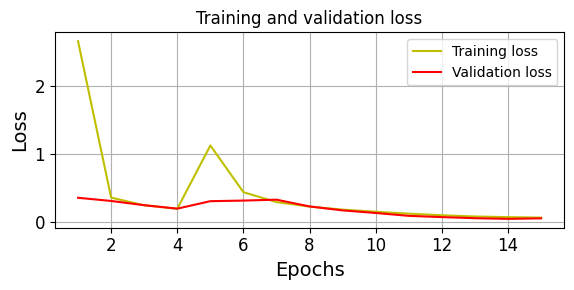

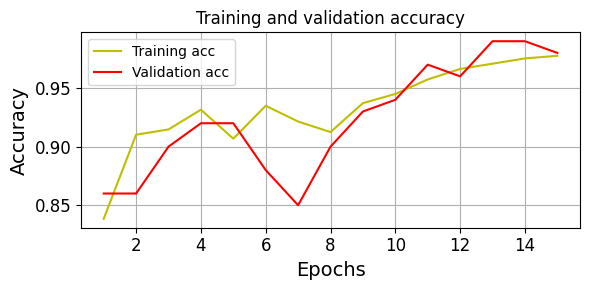

In [ ]:
# ------> Plot loss and accuracy during the training and validation

# Loss
loss = historyAll.history['loss']
val_loss = historyAll.history['val_loss']

# Accuracy
acc = historyAll.history['accuracy']
val_acc = historyAll.history['val_accuracy']

# Epochs
epochs = range(1, len(loss) + 1)

# Plot the curves

plt.figure(figsize=(6,3))
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(6,3))
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# ------> Compute test accuracy once applied the trained model

test_loss, test_acc = modelLeNetAll.evaluate(Xall_test, yall_test)
print('Accuracy ', test_acc)

14/14 [==============================] - 0s 21ms/step - loss: 0.5819 - accuracy: 0.9695
Accuracy  0.9694835543632507


In [ ]:
# ------> Obtain prediccions of the model

predictions = modelLeNetAll.predict(Xall_test)
print("Predictions dim:", predictions.shape)

predicted_labels = np.zeros(len(predictions))

for i in range(len(predictions)):
    predicted_labels[i] = int(np.argmax(predictions[i]))
print("Predicted labels dim:", predicted_labels.shape)

14/14 [==============================] - 0s 21ms/step
Predictions dim: (426, 2)
Predicted labels dim: (426,)


In [ ]:
# ------> Compute the confusion matrix

predicted_labes = predicted_labels.astype(int)

cnf_matrix = tf.math.confusion_matrix(
    yall_test, predicted_labels, num_classes=None, weights=None, dtype=tf.dtypes.int32,
    name=None
)
print(cnf_matrix)

tf.Tensor(
[[191   3]
 [ 10 222]], shape=(2, 2), dtype=int32)
